In [29]:
import numpy as np
from collections import namedtuple
from matplotlib import pyplot as plt
import json
import os
import pandas as pd
import math

In [39]:
def list_dir(dir_path):
    """
    Get all 'lambda_info' prefix files from a directory path.
    @param dir_path: Path of the directory.
    @return: A list of file paths with the prefix, 'lambda_info'.
    """
    files = []

    for f in os.listdir(dir_path):
        if(f.startswith('lambda_info')):
            files.append(os.path.join(dir_path, f))
    
    sorted(files, key=lambda x: x.split('_')[5])
    
    return files
    
    
def parse_filename(filename):
    """
    Extract memory size and cell number info from the filename.
    @param filename: A file name.
    @return: The corresponding memory size and cell number of the file.
    """
    start_idx = filename.find("lambda_info")
    splt = filename[start_idx:].split("_")
    mem = int(splt[3])
    cells = int(splt[5])
    return dict(
        memory=mem,
        cells=cells
    )


def get_durations_status(js):
    """
    Get each lambda invocation's duration and its status.
    @param js: A dict which contains all lambda invocations data.
    @return: A list of lambda invocation duration and status pair.
    """
    results = []
    
    for lambda_info in js['info']:
        results.append((lambda_info['duration_ms'], lambda_info['status']))
    
    return results


def get_experiments(files):
    """
    Get lambda performance metrics data from a list of files.
    @param files: List of file paths.
    @return: A list of performance metrics data in that file.
    """
    experiments = []

    for f in files:
        with open(f, 'r') as fh:
            exp = parse_filename(f)
            js = json.load(fh)
            exp['durations_status'] = get_durations_status(js)
            durations = [i[0] for i in exp['durations_status'] if i[1] == None]
            if len(durations) != 0:
                exp['median'] = np.median([i[0] for i in exp['durations_status'] if i[1] == None])
            experiments += [exp]
    
    return experiments

In [65]:
def filter_errors(durations_status):
    """
    Catergorize a list of durations_status pairs.
    @param durations_status: A list of lambda invocation duration and status pair.
    @return: Duration and status pairs for lambda invocation w/o errors.
    """
    durations_without_error = []
    durations_with_timeout = []
    durations_with_error = []
    
    for duration_status in durations_status:
        if duration_status[1] is None:
            durations_without_error.append(duration_status[0])
        elif duration_status[1] == 'timeout':
            durations_with_timeout.append(duration_status[0])
        elif duration_status[1] == 'error':
            durations_with_error.append(duration_status[0])
    
    return durations_without_error, durations_with_timeout, durations_with_error


def plot_memory(experiments, memory, memory_colors, plt, label):
    """
    Plot experiments data for a particular lambda memory size.
    @param experiments: All experiments data.
    @param memory: Lambda function memory size.
    @param memory_colors: A dict storing corresponding plot color for each memory size.
    @param plt: The plot.
    @param label: Label for the data points in the plot.
    """
    exps = sorted([exp for exp in experiments if exp['memory'] == memory], key=lambda d: d['cells'])
    xs = [float(exp['cells']) for exp in exps if 'median' in exp]
    ys = [exp['median'] for exp in exps if 'median' in exp]
    
    plt.plot(xs, ys, label=label, color=memory_colors[memory])
    
    for exp in exps:
        durations_without_error, durations_with_timeout, durations_with_error = \
            filter_errors(exp['durations_status'])
        plt.scatter([exp['cells']]*len(durations_without_error), durations_without_error, 
                    color=memory_colors[memory], alpha=0.2)
        plt.scatter([exp['cells']]*len(durations_with_timeout), durations_with_timeout, 
                    color=memory_colors[memory], marker='x', alpha=0.5)
        plt.scatter([exp['cells']]*len(durations_with_error), durations_with_error, 
                    color=memory_colors[memory], marker='x', alpha=0.5)
        

def plot_memories(experiments, title):
    """
    Plot experiments data for all lambda memory sizes.
    @param experiments: All experiments data.
    @param title: Plot title.
    """
    memories = sorted(list(set([exp['memory'] for exp in experiments])))
    memory_colors = dict([(count, 'C' + str(num+1)) for num, count in enumerate(memories)])

    plt.figure(figsize=(12,10))
    
    for memory in memories:
        label = 'Lambda memory=' + str(memory) + "MB"
        plot_memory(experiments, memory, memory_colors, plt, label)

    plt.legend(loc='best')
    plt.xlim([0, 512])
    plt.ylim([0, 350000])
    plt.title(title)
    plt.xlabel('Number of matrices')
    plt.ylabel('Duration (ms)')
    plt.show()

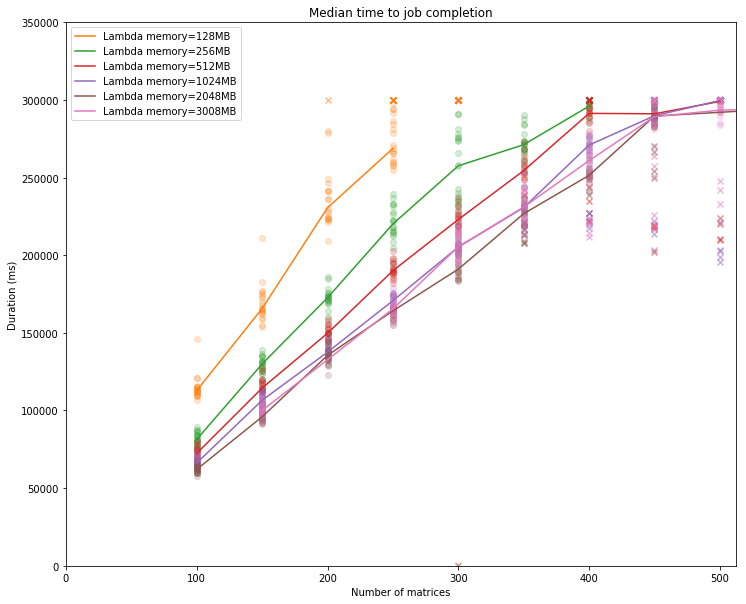

In [66]:
files_v0 = list_dir('../data/v1.0.0')
experiments_v0 = get_experiments(files_v0)
plot_memories(experiments_v0, 'Median time to job completion')

In [70]:
def plot_compare(experiments, lambda_memory, x_limit, y_limit, title):
    """
    Visualize the data points in a plot to compare a set of different experiments with the same
    lambda function memory size.
    """
    plt.figure(figsize=(12,10))
    i = 1
    
    for label in experiments.keys():
        plot_memory(experiments[label], lambda_memory, {lambda_memory: "C{}".format(i)}, plt, label)
        i += 1

    plt.legend(loc='best')
    plt.xlim([0, x_limit])
    plt.ylim([0, y_limit])
    plt.title(title)
    plt.xlabel('Number of matrices')
    plt.ylabel('Duration (ms)')
    plt.show()

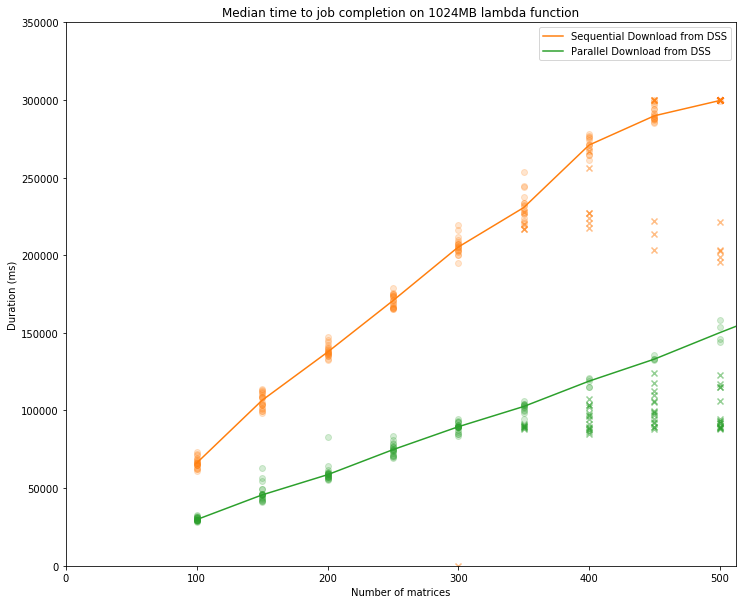

In [71]:
files_v0 = list_dir('../data/v1.0.0')
experiments_v0 = get_experiments(files_v0)

files_v1_parallelism_4 = list_dir('../data/v1.0.1/parallelism_4')
experiments_v1_parallelism_4 = get_experiments(files_v1_parallelism_4)

experiments = dict()
experiments["Sequential Download from DSS"] = experiments_v0
experiments["Parallel Download from DSS"] = experiments_v1_parallelism_4

plot_compare(experiments, 1024, 512, 350000, 'Median time to job completion on {}MB lambda function'.format(1024))

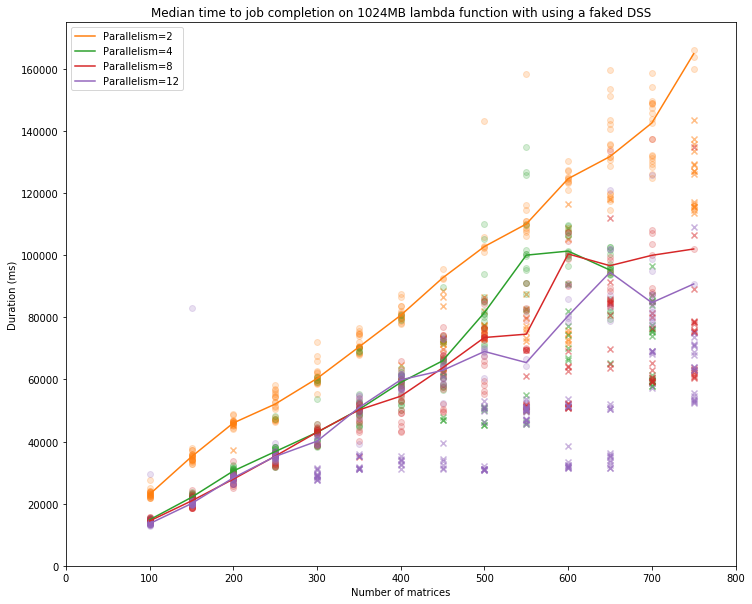

In [72]:
files_v2_parallelism_2 = list_dir('../data/v1.0.2/parallelism_2')
experiments_v2_parallelism_2 = get_experiments(files_v2_parallelism_2)

files_v2_parallelism_4 = list_dir('../data/v1.0.2/parallelism_4')
experiments_v2_parallelism_4 = get_experiments(files_v2_parallelism_4)

files_v2_parallelism_8 = list_dir('../data/v1.0.2/parallelism_8')
experiments_v2_parallelism_8 = get_experiments(files_v2_parallelism_8)

files_v2_parallelism_12 = list_dir('../data/v1.0.2/parallelism_12')
experiments_v2_parallelism_12 = get_experiments(files_v2_parallelism_12)

experiments = dict()
experiments["Parallelism=2"] = experiments_v2_parallelism_2
experiments["Parallelism=4"] = experiments_v2_parallelism_4
experiments["Parallelism=8"] = experiments_v2_parallelism_8
experiments["Parallelism=12"] = experiments_v2_parallelism_12

title = 'Median time to job completion on {}MB lambda function with using a faked DSS'.format(1024)

plot_compare(experiments, 1024, 800, 175000, title)

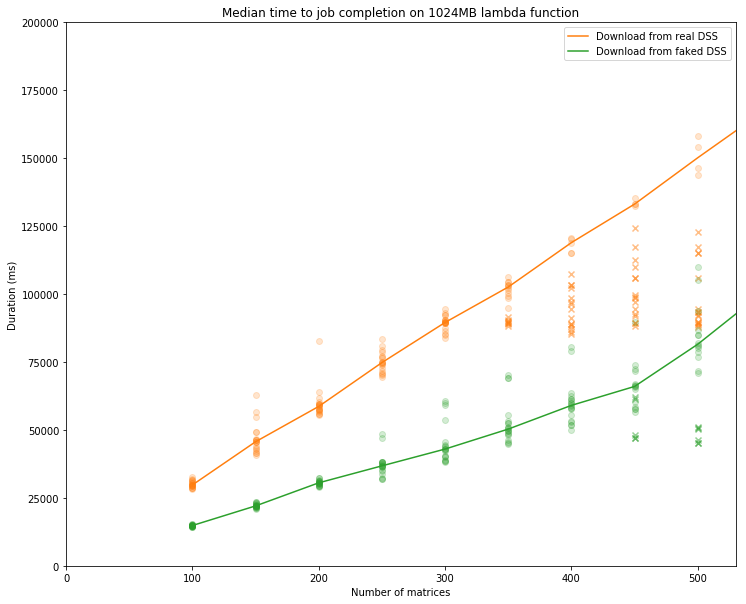

In [73]:
files_v1_parallelism_4 = list_dir('../data/v1.0.1/parallelism_4')
experiments_v1_parallelism_4 = get_experiments(files_v1_parallelism_4)

files_v2_parallelism_4 = list_dir('../data/v1.0.2/parallelism_4')
experiments_v2_parallelism_4 = get_experiments(files_v2_parallelism_4)

experiments = dict()
experiments["Download from real DSS"] = experiments_v1_parallelism_4
experiments["Download from faked DSS"] = experiments_v2_parallelism_4

title = 'Median time to job completion on {}MB lambda function'.format(1024)

plot_compare(experiments, 1024, 530, 200000, title)

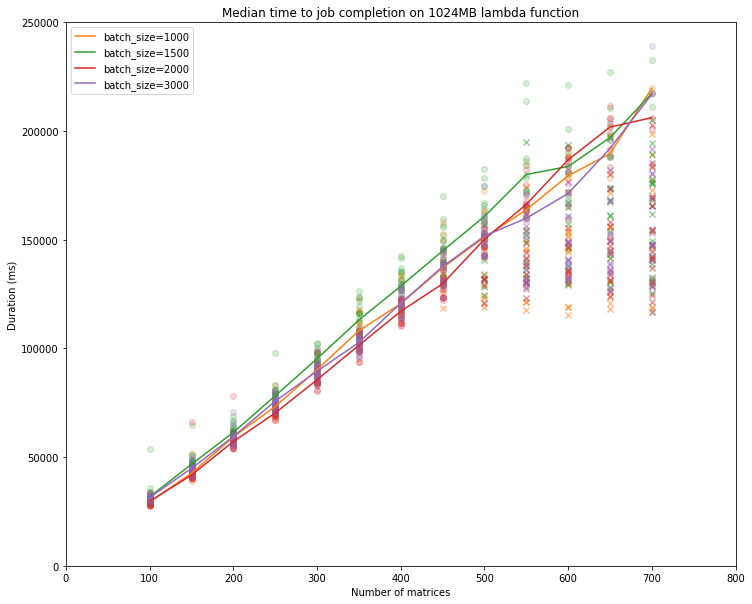

In [75]:
files_v3_parallelism_4_batchsize_1000 = list_dir('../data/v1.0.3/batch_size_1000')
experiments_v3_parallelism_4_batchsize_1000 = get_experiments(files_v3_parallelism_4_batchsize_1000)

files_v3_parallelism_4_batchsize_1500 = list_dir('../data/v1.0.3/batch_size_1500')
experiments_v3_parallelism_4_batchsize_1500 = get_experiments(files_v3_parallelism_4_batchsize_1500)

files_v3_parallelism_4_batchsize_2000 = list_dir('../data/v1.0.3/batch_size_2000')
experiments_v3_parallelism_4_batchsize_2000 = get_experiments(files_v3_parallelism_4_batchsize_2000)

files_v3_parallelism_4_batchsize_3000 = list_dir('../data/v1.0.3/batch_size_3000')
experiments_v3_parallelism_4_batchsize_3000 = get_experiments(files_v3_parallelism_4_batchsize_3000)

experiments = dict()
experiments["batch_size=1000"] = experiments_v3_parallelism_4_batchsize_1000
experiments["batch_size=1500"] = experiments_v3_parallelism_4_batchsize_1500
experiments["batch_size=2000"] = experiments_v3_parallelism_4_batchsize_2000
experiments["batch_size=3000"] = experiments_v3_parallelism_4_batchsize_3000

title = 'Median time to job completion on {}MB lambda function'.format(1024)

plot_compare(experiments, 1024, 800, 250000, title)